In [1]:
using CABLAB

In [2]:
c     = Cube("/Net/Groups/BGI/scratch/DataCube/v0.2.0/low-res")

CABLAB data cube at /Net/Groups/BGI/scratch/DataCube/v0.2.0/low-res
Spatial resolution:  1440x720 at 0.25 degrees.
Temporal resolution: 2001-01-01T00:00:00 to 2012-01-01T00:00:00 at 8daily time steps
Variables:           Rg aerosol_optical_thickness_1610 aerosol_optical_thickness_550 aerosol_optical_thickness_555 aerosol_optical_thickness_659 aerosol_optical_thickness_865 air_temperature_2m bare_soil_evaporation black_sky_albedo burnt_area c_emissions country_mask evaporation evaporative_stress fpar_fluxcom fractional_snow_cover gross_primary_productivity interception_loss land_surface_temperature latent_energy net_ecosystem_exchange open_water_evaporation ozone potential_evaporation precipitation root_moisture sensible_heat snow_sublimation snow_water_equivalent soil_moisture surface_moisture terrestrial_ecosystem_respiration transpiration water_mask water_vapour white_sky_albedo 


In [3]:
vars_bio  = ["burnt_area", "evaporation", "evaporative_stress", "gross_primary_productivity", "interception_loss", "land_surface_temperature", "latent_energy", "net_ecosystem_exchange", "surface_moisture", "terrestrial_ecosystem_respiration", "transpiration"];
vars_atmo = ["aerosol_optical_thickness_550", "air_temperature_2m", "black_sky_albedo", "ozone", "potential_evaporation", "precipitation", "water_vapour", "white_sky_albedo"]
bio_data = getCubeData(c,variable=vars_bio);
atmo_data = getCubeData(c, variable=vars_atmo);

In [4]:
addprocs(10)

10-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11

In [5]:
CABLAB.DAT.init_DATworkers()

We perform some gapfilling, because the pca does not work with gaps

In [7]:
@time cube_bio_filled     = mapCube(gapFillMSC, bio_data);

388.546936 seconds (7.21 M allocations: 234.824 MB, 0.02% gc time)


In [8]:
@time cube_atmo_filled     = mapCube(gapFillMSC, atmo_data);

427.873375 seconds (5.25 M allocations: 171.234 MB, 0.02% gc time)


And we calculate the anomalies

In [9]:
@time cube_bio_anom        = mapCube(removeMSC,cube_bio_filled)

325.150866 seconds (7.33 M allocations: 239.809 MB, 0.03% gc time)


Temporary Data Cube with the following dimensions
Time                Axis with 506 Elements from 2001-01-01T00:00:00 to 2011-12-27T00:00:00
Lon                 Axis with 1440 Elements from -180.0 to 179.75
Lat                 Axis with 720 Elements from 90.0 to -89.75
Variable            Axis with elements: burnt_area evaporation evaporative_stress gross_primary_productivity interception_loss land_surface_temperature latent_energy net_ecosystem_exchange surface_moisture terrestrial_ecosystem_respiration transpiration 


In [10]:
@time cube_atmo_anom        = mapCube(removeMSC,cube_atmo_filled)

224.747956 seconds (5.24 M allocations: 170.803 MB, 0.02% gc time)


Temporary Data Cube with the following dimensions
Time                Axis with 506 Elements from 2001-01-01T00:00:00 to 2011-12-27T00:00:00
Lon                 Axis with 1440 Elements from -180.0 to 179.75
Lat                 Axis with 720 Elements from 90.0 to -89.75
Variable            Axis with elements: aerosol_optical_thickness_550 air_temperature_2m black_sky_albedo ozone potential_evaporation precipitation water_vapour white_sky_albedo 


In [11]:
@everywhere using MultivariateStats
@everywhere function sufficient_dimensions{T}(xout::AbstractArray{T}, xin::AbstractArray{T}, expl_var::Float64 = 0.95)
    if mapreduce(isnan,+,0,xin)>0
        xout[1]=NaN;
        xout[2]=NaN;
        xout[3]=NaN;
        return xout;
    end
    npoint, nvar = size(xin)
    for i in 1:nvar
        _sum  = _ssum = zero(eltype(xin))
        for j in 1:npoint
            _sum  += xin[j,i]
            _ssum += xin[j,i]^2
        end
        _mean  = _sum / npoint
        _smean = _ssum / npoint
        _std = sqrt(_smean - _mean^2 > 0.0 ? _smean-_mean^2 : zero(typeof(_mean)))
        if _std == 0
            _std = 1.0
            #warn("zero variance in column $i")
        end
        for j in 1:npoint
            xin[j,i] -= _mean
            xin[j,i] /= _std
        end
    end
    pca = fit(PCA, xin, pratio = 0.999, method = :svd)
    xout[1] = findfirst(cumsum(principalvars(pca)) / tprincipalvar(pca) .> expl_var)
    xout[2] = pca.projection[:,1]
    xout[3] = pca.projection[:,2}
    return xout;
end 
registerDATFunction(sufficient_dimensions,(TimeAxis,VariableAxis),(),inmissing=(:nan,),outmissing=:nan,no_ocean=1)

CABLAB.DAT.DATFunction(((CABLAB.Cubes.Axes.RangeAxis{DateTime,:Time,CABLAB.Cubes.Axes.YearStepRange},CABLAB.Cubes.Axes.CategoricalAxis{String,:Variable}),),(),(),Any,(:nan,),:nan,1,true,zero,identity,"auto")

First we doe the analysis on the original cube:

In [12]:
@time pcadim_bio=mapCube(sufficient_dimensions,cube_bio_filled);
@time pcadim_atmo=mapCube(sufficient_dimensions,cube_atmo_filled);

 71.078895 seconds (3.48 M allocations: 174.347 MB, 0.16% gc time)
 34.808578 seconds (1.27 M allocations: 76.898 MB, 0.11% gc time)


<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 
 
 1.0 
 2.0 
 3.0 
 4.0 
 5.0
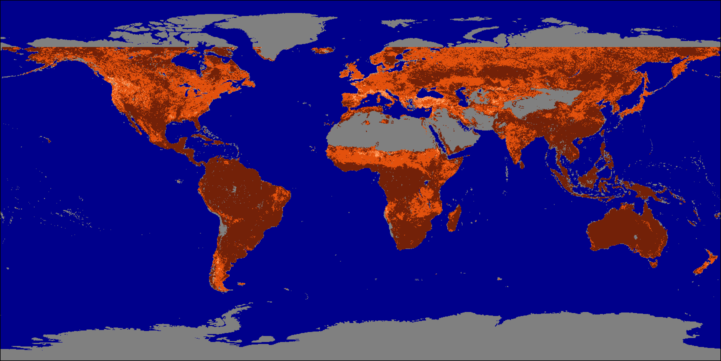

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 
 
 1.0 
 2.0 
 3.0 
 4.0 
 5.0
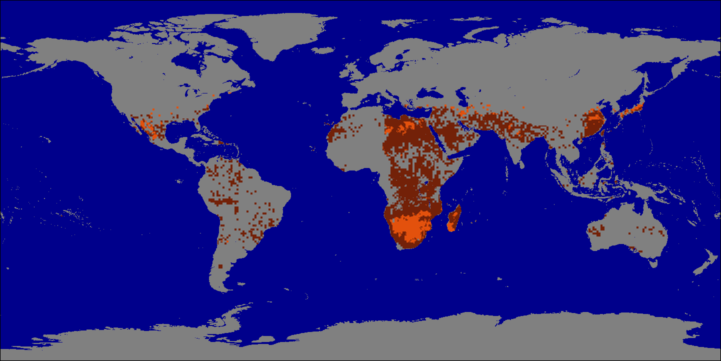

In [15]:
display(plotMAP(pcadim_bio,dmin=1.f0,dmax=5.f0))
display(plotMAP(pcadim_atmo,dmin=1.f0,dmax=5.f0))

And on the anomalies only:

In [18]:
pcadim_bio_anom=mapCube(sufficient_dimensions,cube_bio_anom);
pcadim_atmo_anom=mapCube(sufficient_dimensions,cube_atmo_anom);

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 
 
 1.0 
 2.0 
 3.0 
 4.0 
 5.0
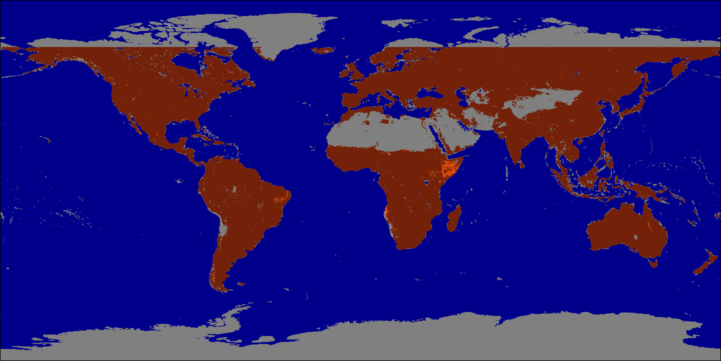

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 
 
 1.0 
 2.0 
 3.0 
 4.0 
 5.0
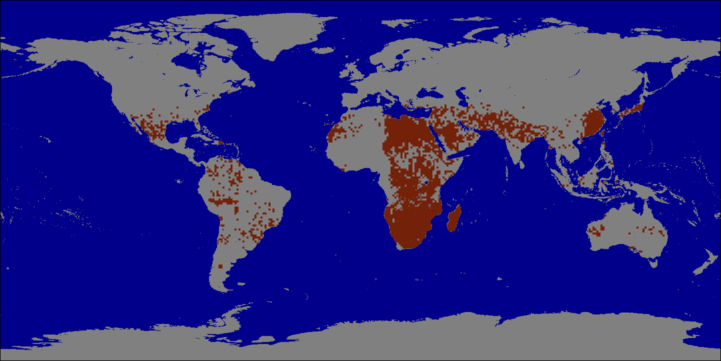

In [19]:
display(plotMAP(pcadim_bio_anom,dmin=1.f0,dmax=5.f0))
display(plotMAP(pcadim_atmo_anom,dmin=1.f0,dmax=5.f0))